---

## Introduction to 3D Geometry Manipulation with Python and VTK

In this notebook, we explore how to manipulate and process 3D geometry using Python combined with a powerful library called VTK (Visualization Toolkit). VTK is an open-source software system that provides tools for 3D computer graphics, image processing, and visualization. It's widely used in scientific computing to handle complex geometrical data.

### Why Use Python with VTK?

Python is a versatile programming language known for its simplicity and readability, making it an excellent choice for beginners. When paired with VTK, Python becomes a powerful tool for processing and visualizing 3D data. This capability is particularly useful in fields like engineering, medical imaging, and scientific research, where working with complex 3D models is common.

### What You Will Learn

In the code examples below, you will learn how to:

1. **Read 3D Models**: Load geometry from STL files, which are commonly used in 3D printing and CAD software.
2. **Extract Information**: Compute the bounding box of the geometry, giving you a simple way to understand the size and position of the model.
3. **Modify Geometry**: Adjust the geometry to have a standardized size or position, such as scaling it to a specific height or translating it so its lowest point is at the origin (0,0,0).
4. **Reduce Complexity**: Simplify the model by reducing the number of triangles, making it easier to handle without significantly altering its appearance.
5. **Save Changes**: Write the modified geometry back into file formats that can be used in other applications, such as OBJ or STL files.

Each function in the code is documented with "docstrings" which are descriptions that explain what the function does, its parameters, and what it returns. These are helpful for anyone who wants to understand or use your code later.

### The Code Functions

- `get_polydata(stl_path)`: Reads an STL file and converts it to a format (vtkPolyData) that can be easily manipulated using VTK.
- `get_bounding_box(polydata)`: Calculates the minimal box that can contain the 3D model, known as the bounding box.
- `normalize_polydata(polydata, target_height)`: Transforms the model so its lowest point is at zero and rescales it to a given height.
- `save_obj(polydata, obj_path)` and `save_stl(polydata, stl_path)`: Save the manipulated data back into common 3D file formats (OBJ and STL).

Using Python and VTK together, you can automate and simplify many tasks related to 3D data processing, which would otherwise be tedious and error-prone if done manually. This combination is not only efficient but also opens up numerous possibilities for creating advanced applications and visualizations.


In [1]:
import vtk

def get_polydata(stl_path):
    """
    Read an STL file and convert it to vtkPolyData.

    Args:
    stl_path (str): The file path to the STL file to be read.

    Returns:
    vtk.vtkPolyData: The polydata extracted from the STL file.
    """
    reader = vtk.vtkSTLReader()
    reader.SetFileName(stl_path)
    reader.Update()
    
    polydata = reader.GetOutput()

    return polydata

def get_bounding_box(polydata):    
    """
    Calculate the axis-aligned bounding box of a vtkPolyData object.

    Args:
    polydata (vtk.vtkPolyData): The polydata for which the bounding box is calculated.

    Returns:
    tuple: A tuple of six floats representing the bounding box (xmin, xmax, ymin, ymax, zmin, zmax).
    """
    bounds = polydata.GetBounds()
    return bounds

def normalize_polydata(polydata, target_height):    
    """
    Normalize the position and scale of a vtkPolyData object to have its minimum coordinates at (0,0,0) and its maximum z-coordinate at the specified height.

    Args:
    polydata (vtk.vtkPolyData): The polydata to normalize.
    target_height (float): The desired maximum z-coordinate after normalization.

    Returns:
    vtk.vtkPolyData: The normalized polydata.
    """
    # Get current bounds
    bounds = polydata.GetBounds()
    xmin, xmax, ymin, ymax, zmin, zmax = bounds

    # Calculate the translation needed to shift the minimum x, y, z to 0
    translation = [-xmin, -ymin, -zmin]

    # Calculate scale factor for the z-axis to meet the target height
    current_height = zmax - zmin
    scale_factor = target_height / current_height if current_height != 0 else 1

    # Create a transform that includes translation and scaling
    transform = vtk.vtkTransform()
    transform.Translate(translation)
    transform.Scale(scale_factor, scale_factor, scale_factor)

    # Apply the transformation to the polydata
    transform_filter = vtk.vtkTransformPolyDataFilter()
    transform_filter.SetTransform(transform)
    transform_filter.SetInputData(polydata)
    transform_filter.Update()

    # Return the transformed polydata
    return transform_filter.GetOutput()

def save_obj(polydata, obj_path):    
    """
    Save vtkPolyData to a file in OBJ format.

    Args:
    polydata (vtk.vtkPolyData): The polydata to save.
    obj_path (str): The file path where the OBJ file will be saved.
    """
    obj_writer = vtk.vtkOBJWriter()
    obj_writer.SetFileName(obj_path)
    obj_writer.SetInputDataObject(polydata)
    obj_writer.Write()

def save_stl(polydata, stl_path):    
    """
    Save vtkPolyData to a file in STL format.

    Args:
    polydata (vtk.vtkPolyData): The polydata to save.
    stl_path (str): The file path where the STL file will be saved.
    """
    stl_writer = vtk.vtkSTLWriter()
    stl_writer.SetFileName(stl_path)
    stl_writer.SetInputDataObject(polydata)
    stl_writer.Write()


def decimate_polydata(polydata, reduction_factor=0.5):
    """
    Reduce the number of triangles in a vtkPolyData object while trying to preserve topology.

    Args:
    polydata (vtkPolyData): The original polydata to decimate.
    reduction_factor (float): The fraction of the original mesh to remove. 
                              0.5 means reduce by 50%, etc.

    Returns:
    vtkPolyData: The decimated polydata object.
    """
    # Check if the reduction factor is valid
    if not 0 < reduction_factor < 1:
        raise ValueError("Reduction factor must be between 0 and 1.")

    # Set up the decimation filter
    decimator = vtk.vtkDecimatePro()
    decimator.SetInputData(polydata)
    decimator.SetTargetReduction(reduction_factor)
    # decimator.PreserveTopologyOn()  # Ensure topology is preserved
    decimator.Update()

    # Get the output of the decimator
    decimated_polydata = decimator.GetOutput()
    return decimated_polydata


I recommend using paraview to view the 3D models. You can download it from [here](https://www.paraview.org/download/). However, you might also want to explore the use of pyvista for 3D visualization in Python. You can install it using `pip install pyvista`.

In [2]:
import pyvista as pv

# Enable notebook plotting capabilities for PyVista (mileage will vary
# on whether you are using VSCode or JupyterLab...).
pv.set_jupyter_backend('static')

def display_polydata_with_edges(polydata):
    """
    Displays a VTK polydata object with surface rendering and edges in a Jupyter notebook.

    Args:
    polydata (vtk.vtkPolyData): A VTK polydata object to render.
    """
    # Wrap the VTK polydata object with PyVista's PolyData class
    pv_polydata = pv.PolyData(polydata)

    # Create a plotter
    plotter = pv.Plotter()
    
    # Add the polydata to the plotter with a surface representation
    plotter.add_mesh(pv_polydata, color='lightblue', show_edges=True, edge_color='black')

    # Show the plotter
    plotter.show()

---

## Processing a 3D Model for Standardization and Export

The code snippet provided demonstrates a streamlined process using the VTK library in Python to handle a 3D model from an STL file named "OnlyConvertToOBJ.stl". This process involves reading, normalizing, and saving the model in different file formats. Here's a breakdown of what each line of code accomplishes:

1. **Reading the STL File**:
   - `stl = 'alien.stl'` sets the path to the STL file that we want to process.
   - `polydata = get_polydata(stl)` utilizes the `get_polydata` function to read the STL file and convert it into `vtkPolyData`, a versatile format suitable for manipulation using VTK. This format is essential for enabling modifications and detailed analysis of the 3D model.

2. **Normalizing the Model**:
   - `polydata = normalize_polydata(polydata, 70)` employs the `normalize_polydata` function to modify the model's position and scale. It adjusts the model so that its lowest point is at the origin (0, 0, 0) and rescales it so the maximum height along the Z-axis reaches 70 units. Normalizing the model ensures that its size is consistent, which is particularly useful for comparison and integration with other models or within various simulation environments.

3. **Saving the Processed Model**:
   - `save_obj(polydata, 'alien.obj')` save the normalized model in OBJ format. Saving the model in this format provides flexibility for use in different applications such as 3D printing.

### Benefits of This Workflow

This workflow illustrates an effective approach to manage 3D data by ensuring that the model is uniform in size and readily usable in various applications. The normalization process not only standardizes the dimensions of the model but also aids in reducing potential issues during rendering or analysis due to inconsistent scale. Additionally, by exporting the model in both OBJ and STL formats, the utility of the processed data is maximized, accommodating a wide range of tools and applications.

Overall, the procedure described is ideal for preparing 3D models for further use, whether it be in digital media, scientific research, or other technical fields that utilize 3D data.

---

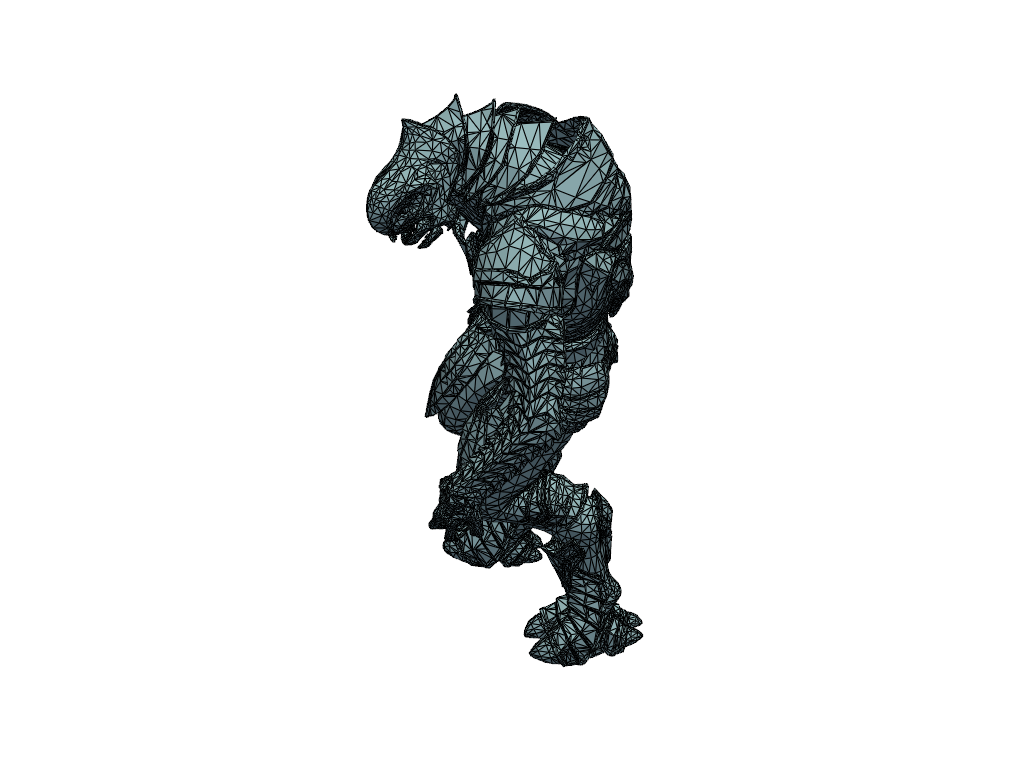

In [3]:
# Alien
stl = 'alien.stl'
alien = get_polydata(stl)

# Display the polydata with edges
display_polydata_with_edges(alien)

In [4]:
alien = normalize_polydata(alien, 70)

save_obj(alien, 'alien.obj')

## Processing a 3D Model with VTK in Python

The code snippet you see here demonstrates a practical application of the VTK library in Python to process a large 3D model stored in an STL file named "halo-full.stl." This example walks through reading, normalizing, simplifying, and then saving the model in different formats. Here's what each line of the code does:

1. **Reading the STL File**: 
   - `stl = 'halo-full.stl'` sets the file name of the STL file we are going to work with.
   - `polydata = get_polydata(stl)` uses the `get_polydata` function to read the STL file and convert it into `vtkPolyData`, a format that VTK can manipulate. This format allows for detailed analysis and modification of the model.

2. **Normalizing the Model**: 
   - `polydata = normalize_polydata(polydata, 65)` calls the `normalize_polydata` function to adjust the model's position and scale. It translates the model so that its lowest point lies at the origin (0, 0, 0) and scales it so that the highest point along the Z-axis is at 65 units. This step is crucial for standardizing the model size for consistent processing or display.

3. **Decimating the Model**: 
   - `polydata = decimate_polydata(polydata, reduction_factor=0.78)` reduces the complexity of the model using the `decimate_polydata` function. This function aims to decrease the number of triangles in the model by 78% (since the reduction factor is 0.78, meaning we remove 78% of the original model). Reducing the number of triangles makes the model easier to handle, especially beneficial for rendering or simulation purposes.

4. **Saving the Processed Model**: 
   - `save_obj(polydata, 'halo.obj')` and `save_stl(polydata, 'halo.stl')` save the processed model in both OBJ and STL formats. Saving in different formats provides flexibility, as different software tools and applications may require different file types.

### Why This Workflow is Useful

This workflow demonstrates how to effectively process and manage 3D data, making the model more manageable and suitable for various applications. By normalizing and decimating the model, the code ensures that the model is not only uniform in size but also lighter in terms of data, which is essential for performance in rendering and analysis. Furthermore, saving in multiple formats increases the utility of the processed data across different platforms and uses.

Overall, this approach provides a robust method for preparing 3D models for further use in a range of fields such as 3D printing, gaming and scientific visualization.


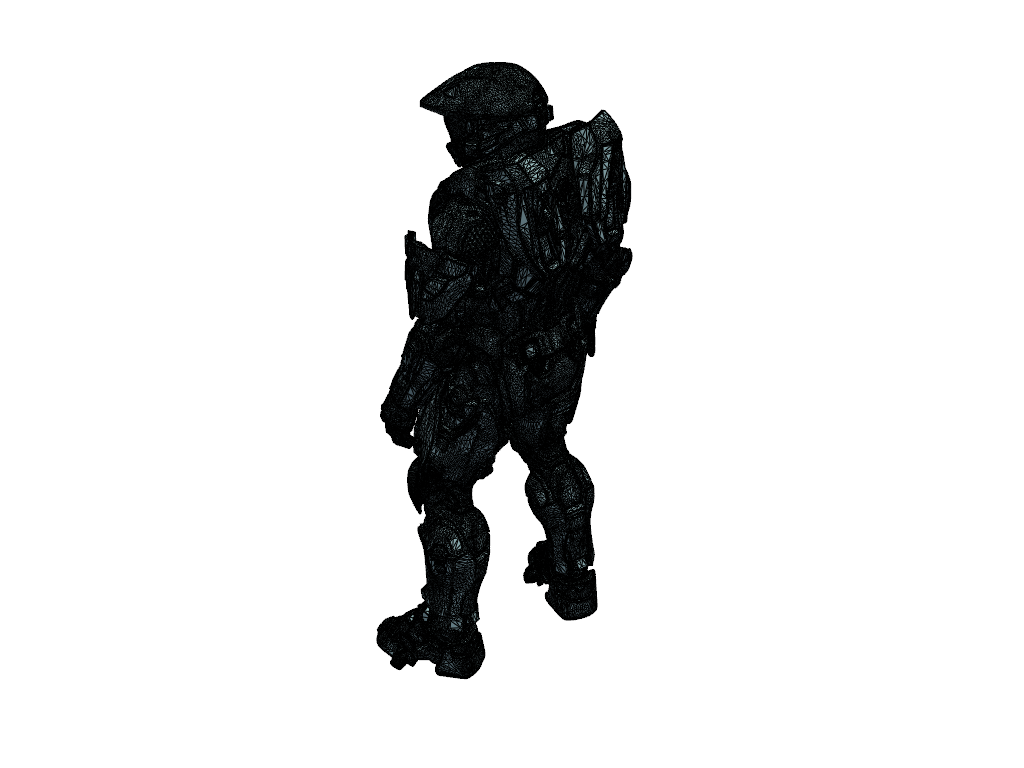

In [5]:
# Halo
stl = 'halo-full.stl'
halo = get_polydata(stl)
display_polydata_with_edges(halo)

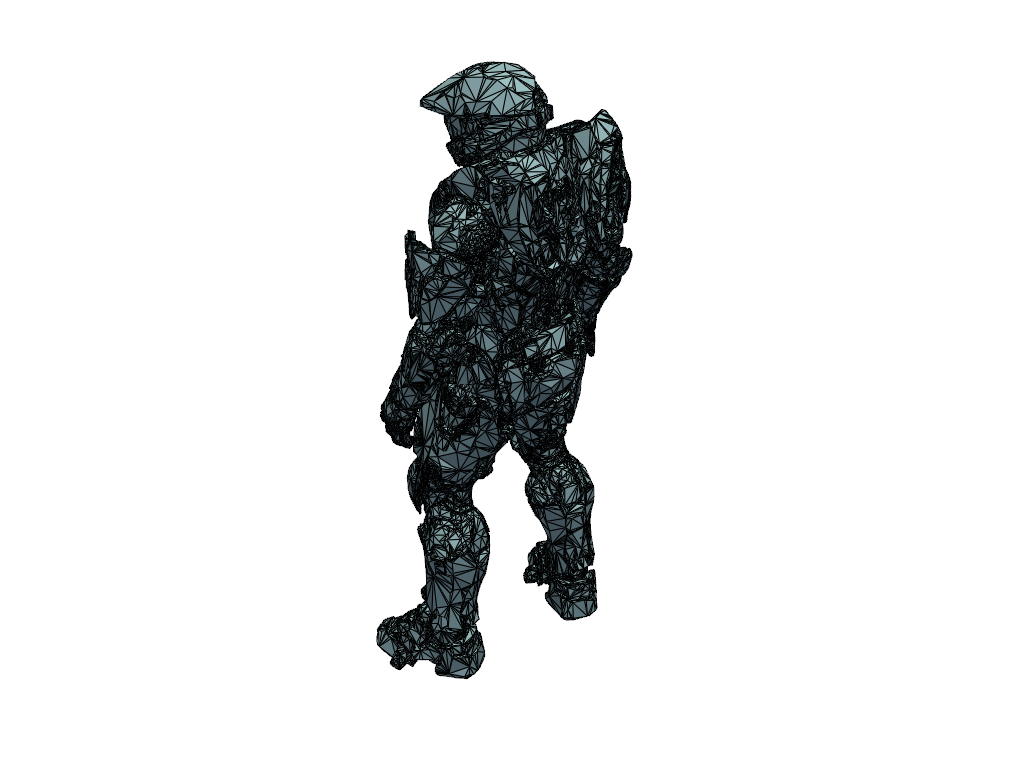

In [6]:
halo = normalize_polydata(halo, 65)
halo = decimate_polydata(halo, reduction_factor=0.78)

display_polydata_with_edges(halo)

In [7]:
save_obj(halo, 'halo.obj')
save_stl(halo, 'halo.stl')
